In [151]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from ta.momentum import RSIIndicator 
from ta.volatility import BollingerBands
%matplotlib inline

In [152]:
stock_name = input('Enter NSE Stock Name: ').upper()
date_entry = input('Enter a date in yyyy,m,d format')
year, month, day = map(int, date_entry.split(','))
start_date= datetime.date(year, month, day)
end_date = date.today()

# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

In [153]:
df = stock_df(stock_name, start_date, end_date)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-01-01,SBIN,EQ,295.90,297.50,300.70,293.85,300.70,299.60,296.77,11837127,3.512877e+14,69723,1668134,0.1409
2019-01-02,SBIN,EQ,299.60,299.10,302.50,293.10,293.80,293.90,298.20,25559853,7.622010e+14,162196,7019907,0.2746
2019-01-03,SBIN,EQ,293.90,295.00,295.55,290.10,291.05,291.10,292.87,17548347,5.139324e+14,110626,6361787,0.3625
2019-01-04,SBIN,EQ,291.10,292.10,299.00,291.50,297.30,297.65,296.18,19514041,5.779686e+14,142962,4963982,0.2544
2019-01-07,SBIN,EQ,297.65,301.05,301.50,295.20,296.55,296.30,298.25,14579399,4.348321e+14,113554,4817960,0.3305


In [154]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-01,297.50,300.70,293.85,299.60,11837127
2019-01-02,299.10,302.50,293.10,293.90,25559853
2019-01-03,295.00,295.55,290.10,291.10,17548347
2019-01-04,292.10,299.00,291.50,297.65,19514041
2019-01-07,301.05,301.50,295.20,296.30,14579399


In [155]:
# Moving Averages
df['MA100'] = df['Close'].rolling(100).mean()
df['MA200'] = df['Close'].rolling(200).mean()
df['Signal'] = 0
df['Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
df['Position'] = df['Signal'].diff()
df.tail()

C:\Users\chinn\AppData\Local\Temp\ipykernel_17556\1677998325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA100'] = df['Close'].rolling(100).mean()
C:\Users\chinn\AppData\Local\Temp\ipykernel_17556\1677998325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA200'] = df['Close'].rolling(200).mean()
C:\Users\chinn\AppData\Local\Temp\ipykernel_17556\1677998325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,Open,High,Low,Close,Volume,MA100,MA200,Signal,Position
Date,,,,,,,,,
2022-06-13,454.00,454.05,442.10,445.85,13426836,492.1760,482.60050,1,0.0
2022-06-14,445.00,449.25,443.35,448.10,11351101,491.5170,482.75300,1,0.0
2022-06-15,448.95,455.45,448.60,451.35,9920926,490.9625,482.92850,1,0.0
2022-06-16,455.15,457.75,440.15,441.60,10780703,490.2205,483.08275,1,0.0
2022-06-17,440.00,447.55,437.25,441.00,14326050,489.5165,483.22550,1,0.0


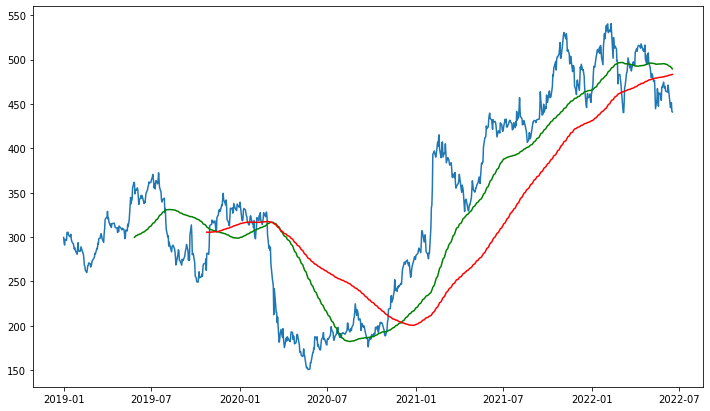

In [156]:
plt.figure(figsize=(12,7))
plt.plot(df.Close)
plt.plot(df.Close.rolling(100).mean(), color='green')
plt.plot(df.Close.rolling(200).mean(), color='red')

In [157]:
df.shape

(859, 9)

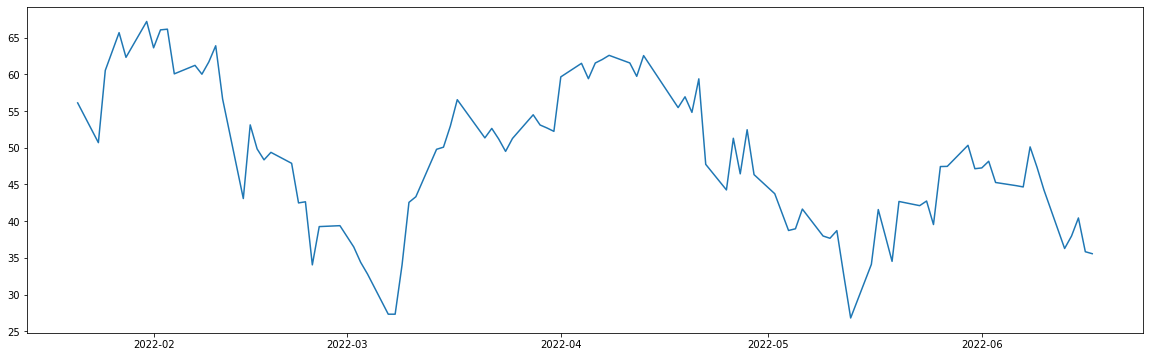

In [158]:
# Relative Strength Index
df['RSI'] = RSIIndicator(df['Close'], 14).rsi()
plt.figure(figsize=(20,6))
plt.plot(df.RSI[-100:])

In [159]:
# Bollinger Bands
BB = BollingerBands(df['Close'], 20, 2.5)
df['BBL'] = BB.bollinger_lband()
df['BBH'] = BB.bollinger_hband()
bbl = BB.bollinger_lband()
bbh = BB.bollinger_hband()
len(bbl), len(bbh)

(859, 859)

<AxesSubplot:xlabel='Date'>

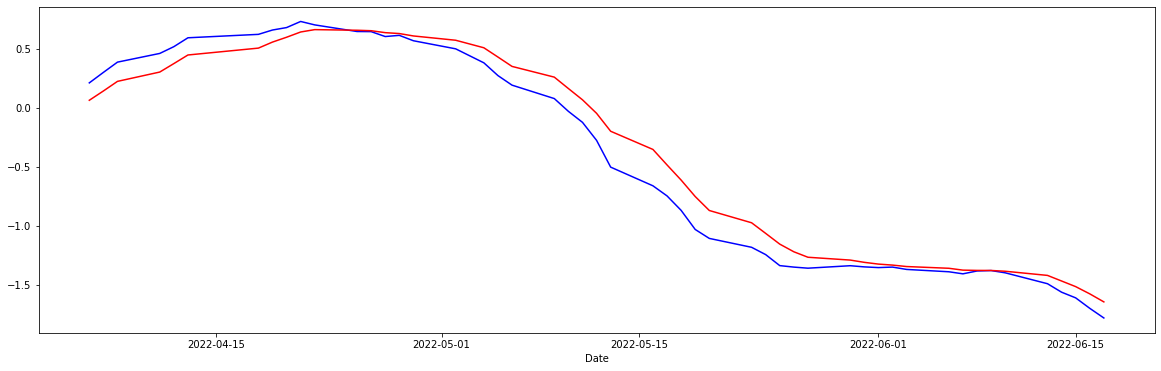

In [160]:
shortema = df.Close.ewm(span=46, min_periods=12, adjust=False).mean()
longema = df.Close.ewm(span=52, min_periods=26, adjust= False).mean()
MACD = shortema - longema
signal = MACD.ewm(span=5, min_periods=9).mean()
MACD[-50:].plot(figsize=(20,6), color='blue')
signal[-50:].plot(figsize=(20,6), color='red')

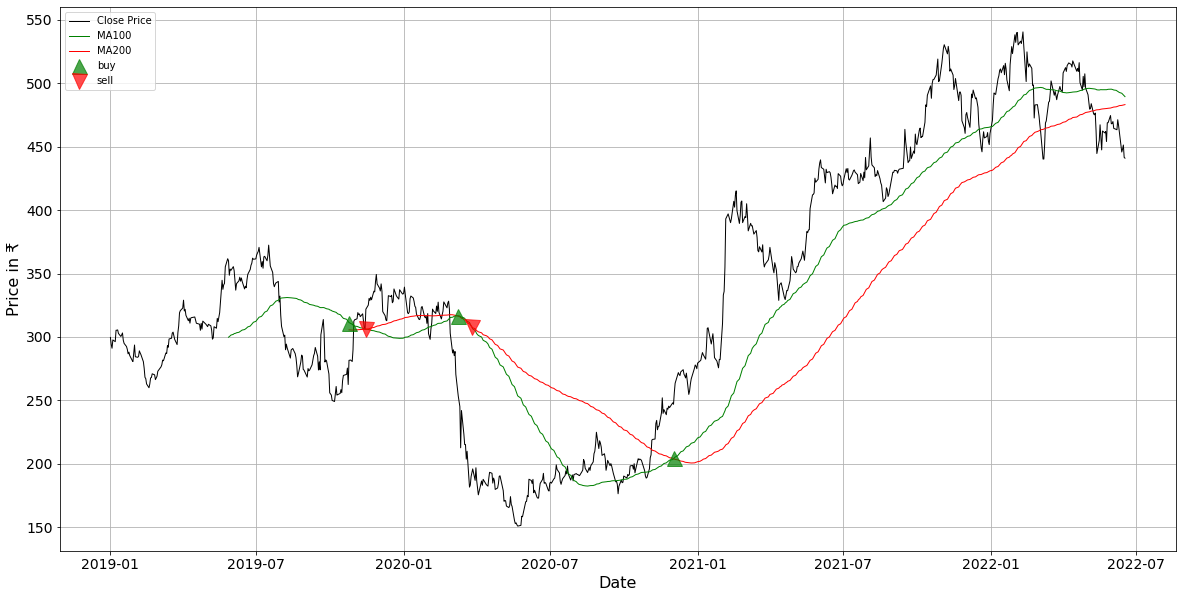

In [161]:
# Moving Averages
def moving_average(df, short_window = 100, long_window = 200):
    df['MA100'] = df['Close'].rolling(short_window).mean()
    df['MA200'] = df['Close'].rolling(long_window).mean()
    df['Signal'] = 0
    df['Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df['Position'] = df['Signal'].diff()

    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df['Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
    df['MA100'].plot(color = 'g', lw = 1, label = 'MA100')
    df['MA200'].plot(color = 'r', lw = 1, label = 'MA200') 

    # plot 'buy' signals
    plt.plot(df[df['Position'] == 1].index, 
            df['MA100'][df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df[df['Position'] == -1].index, 
            df['MA100'][df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.legend()
    plt.grid()
    plt.show()

moving_average(df)

In [162]:
rsi = RSIIndicator(df['Close'], 14).rsi()
def relative_strength_index(df, rsi):
    if(rsi[-7:].mean() > 80):
        print('Alert : Do Not buy this stock, market value exceeded 80%')
    if(rsi[-7:].mean() < 20):
        print('Alert : Do Not sell this stock, market value below 20%')
    else:
        if(rsi[-7:].mean() > 50):
            return 'Prefer Buy'
        elif(rsi[-7:].mean() < 50):
            return 'Prefer Sell'
        else:
            return 'Prefer Hold'
    
relative_strength_index(df, rsi)

'Prefer Sell'

In [163]:
df

,Open,High,Low,Close,Volume,MA100,MA200,Signal,Position,RSI,BBL,BBH
Date,,,,,,,,,,,,
2019-01-01,297.50,300.70,293.85,299.60,11837127,NaN,NaN,0,NaN,NaN,NaN,NaN
2019-01-02,299.10,302.50,293.10,293.90,25559853,NaN,NaN,0,0.0,NaN,NaN,NaN
2019-01-03,295.00,295.55,290.10,291.10,17548347,NaN,NaN,0,0.0,NaN,NaN,NaN
2019-01-04,292.10,299.00,291.50,297.65,19514041,NaN,NaN,0,0.0,NaN,NaN,NaN
2019-01-07,301.05,301.50,295.20,296.30,14579399,NaN,NaN,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,454.00,454.05,442.10,445.85,13426836,492.1760,482.60050,1,0.0,36.271106,445.279387,481.570613
2022-06-14,445.00,449.25,443.35,448.10,11351101,491.5170,482.75300,1,0.0,37.966359,442.660877,482.269123
2022-06-15,448.95,455.45,448.60,451.35,9920926,490.9625,482.92850,1,0.0,40.431276,441.543923,482.721077


In [164]:
df['buy_signal'] = np.where(df['Close'] < df['BBL'],True, False)
df['sell_signal'] = np.where(df['Close'] > df['BBH'],True, False)
df = df.dropna()

In [165]:
buy = []
sell = []
position = 0
for i in range(len(df)):
    if(df.BBL[i] > df.Close[i]):
        if position == 0:
            buy.append(i)
            position = 1
    elif(df.BBH[i] < df.Close[i]):
        if position == 1:
            sell.append(i)
            position = 0

len(buy), len(sell)

(3, 2)

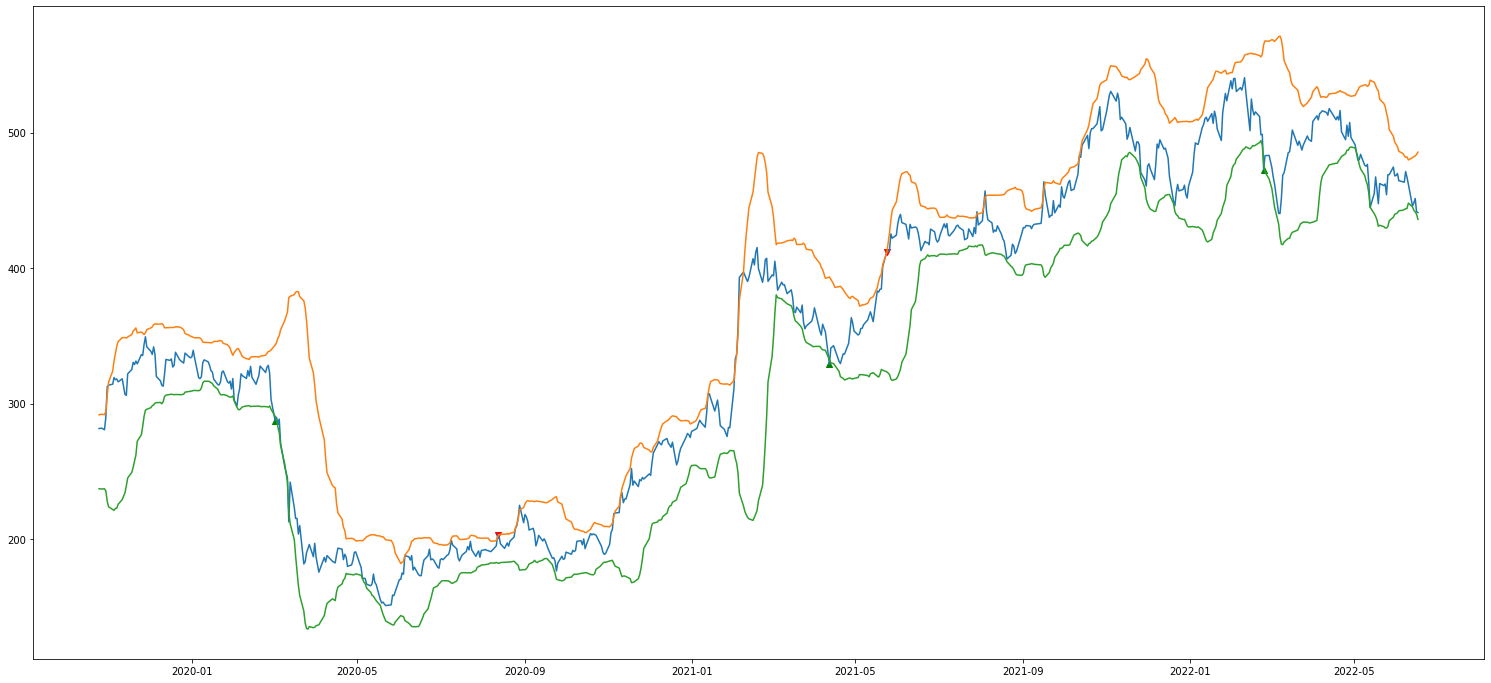

In [166]:
plt.figure(figsize=(26,12))
plt.plot(df[['Close', 'BBH', 'BBL']])
plt.scatter(df.iloc[buy].index, df.iloc[buy].Close, color='green', marker='^')
plt.scatter(df.iloc[sell].index, df.Close[sell], color='red', marker='v')
plt.show()